## 주택 가격 예측 : 회귀 문제

### 회귀 문제 : 개별적인 카테고리 대신 연속적인 값 예측 (ex. 기온 등)

#### 데이터 load (보스턴 주택 가격 데이터) - 각 데이터별 특성은 스케일이 다름. (어떠한 특성은 0-1 어떠한 특성은 1-100 등일 수 있다는 뜻)

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets),(test_data, test_targets)= boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 7us/step


In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

#### 각 샘플별로 113개의 수치 특성을 가지고 있음. (범죄율, 방의 개수 등)

### 서로 다른 스케일 값을 신경망에 주입하면 문제가 되므로 정규화를 수행. 각 특성별로 평균을 빼고 표준편차로 나눠 정규화를 진행한다. 
(테스트 데이터의 값은 사용하면 안되므로 테스트 데이터에 대한 정규화도 train data의 평균과 표준편차를 이용한다.)

In [7]:
mean = train_data.mean(axis=0)
train_data-=mean
std = train_data.std(axis=0)
train_data/=std

test_data-=mean
test_data/=std

### 모델 만들기

In [14]:
from keras import models
from keras import layers

def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])        # mse (평균 제곱 오차) 손실함수 이용, mae는 평균 절대 오차. 모니터링을 위한 지표로 씀. 예측과 타깃 사이 거리의 절댓값
    return model

#### 마지막 층이 하나의 유닛을 가지고 있으며 활성화함수가 없음.  -> 스칼라 회귀를 위한 구성
(활성화 함수 이용 시 출력값의 범위를 제한하게 됨)

### 데이터의 검증을 위해 K-겹 교차 검증을 이용
데이터를 k개로 분할하고 각 폴드별로 다른 데이터셋을 검증용으로 이용

In [15]:
import numpy as np

k=4
num_val_samples = len(train_data)//k
num_epochs=100
all_scores=[]

for i in range(k):
    print("처리중인 폴드 #",i)
    val_data=train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets= train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data= np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets= np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model=build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [16]:
all_scores

[1.9633641242980957,
 3.3308029174804688,
 2.8366971015930176,
 2.2372512817382812]

In [17]:
np.mean(all_scores)

2.592028856277466

#### 약 2600달러정도 차이가 난다.

### 신경망을 200 에포크동안 훈련시키고 개선 정도 확인을 위해 에포크별 점수를 기록

In [19]:
num_epochs=200
all_mae_histories=[]

for i in range(k):
    print("처리중인 폴드 #",i)
    val_data=train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets= train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data= np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets= np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model=build_model()
    history=model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history=history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [25]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

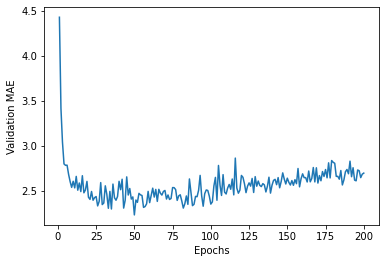

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

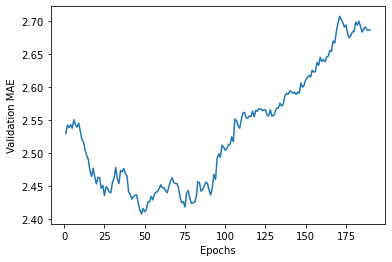

In [27]:
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history=smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 80번째 에포크 이후부터는 검증 MAE의 감소가 멈춤. 이후로는 과대적합

### 최종 모델 훈련

In [28]:
model=build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 225us/step


In [29]:
test_mae_score

29.480775833129883

### 여전히 2948 달러정도의 오차가 생김